Ensemble Methods Baseline

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [ ]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'POST'  # Change to 'PRE' for pre-decision analysis
# ============================================================================

print(f"\n{'='*70}")
print(f"ENSEMBLE METHODS BASELINE: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [ ]:
# Load pre-extracted features
with open('../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"\nFeature counts:")
print(f"  Physiology: {len(physio_cols)}")
print(f"  Behavior: {len(behavior_cols)}")
print(f"  Gaze: {len(gaze_cols)}")
print(f"  Total: {len(physio_cols) + len(behavior_cols) + len(gaze_cols)}")

## Prepare Combined Features

In [3]:
# Impute and combine
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])
X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])

X_combined = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)
y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Combined features: {X_combined.shape}")

Combined features: (12511, 40)


## Define Base Models

In [4]:
def get_base_models():
    """
    Create base models for ensemble.
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
            random_state=42,
            n_jobs=-1
        ),
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
    }
    return models

## Stacking Ensemble with LOSO

In [5]:
def run_loso_stacking(X, y, subjects, base_models, meta_model_name='Logistic Regression'):
    """
    Run LOSO cross-validation with stacking ensemble.
    """
    print("="*70)
    print(f"Stacking Ensemble (Meta: {meta_model_name})")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    base_model_preds = {name: [] for name in base_models.keys()}
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train base models and get predictions
        train_meta_features = []
        test_meta_features = []
        
        for name, model in base_models.items():
            # Clone the model for this fold
            if name == 'Random Forest':
                m = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                          random_state=42, n_jobs=-1)
            elif name == 'Logistic Regression':
                m = LogisticRegression(class_weight='balanced', max_iter=1000, 
                                      random_state=42, n_jobs=-1)
            elif name == 'XGBoost':
                m = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                     scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                                     random_state=42, n_jobs=-1)
            elif name == 'LightGBM':
                m = lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                      class_weight='balanced', random_state=42, 
                                      n_jobs=-1, verbose=-1)
            
            m.fit(X_train, y_train)
            
            # Get probability predictions
            train_proba = m.predict_proba(X_train)[:, 1]
            test_proba = m.predict_proba(X_test)[:, 1]
            
            train_meta_features.append(train_proba)
            test_meta_features.append(test_proba)
            
            # Store for later analysis
            base_model_preds[name].extend(m.predict(X_test))
        
        # Stack predictions as meta-features
        X_train_meta = np.column_stack(train_meta_features)
        X_test_meta = np.column_stack(test_meta_features)
        
        # Train meta-learner
        if meta_model_name == 'Logistic Regression':
            meta_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
        else:
            meta_model = RandomForestClassifier(n_estimators=50, class_weight='balanced', 
                                               max_depth=3, random_state=42)
        
        meta_model.fit(X_train_meta, y_train)
        
        # Predict
        y_pred = meta_model.predict(X_test_meta)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    # Base model accuracies
    print(f"\nBase Model Accuracies:")
    for name in base_models.keys():
        base_acc = accuracy_score(all_y_true, base_model_preds[name])
        print(f"  {name}: {base_acc:.4f}")
    
    return {
        'model_name': f'Stacking ({meta_model_name})',
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred,
        'base_model_preds': base_model_preds
    }

# Run stacking with Logistic Regression meta-learner
base_models = get_base_models()
results_stacking_lr = run_loso_stacking(X_combined, y, subjects, base_models, 'Logistic Regression')

Stacking Ensemble (Meta: Logistic Regression)


/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have 


Overall Accuracy: 0.6809
Overall F1 Score: 0.6641
Mean Subject Accuracy: 0.6792 ± 0.0134 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.38      0.45      4273
           1       0.72      0.84      0.78      8238

    accuracy                           0.68     12511
   macro avg       0.63      0.61      0.61     12511
weighted avg       0.66      0.68      0.66     12511


Base Model Accuracies:
  Random Forest: 0.6828
  Logistic Regression: 0.6522
  XGBoost: 0.6475
  LightGBM: 0.6498


/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Stacking with Random Forest Meta-Learner

In [6]:
# Run stacking with Random Forest meta-learner
results_stacking_rf = run_loso_stacking(X_combined, y, subjects, base_models, 'Random Forest')

Stacking Ensemble (Meta: Random Forest)


/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have 


Overall Accuracy: 0.6833
Overall F1 Score: 0.6621
Mean Subject Accuracy: 0.6817 ± 0.0135 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.36      0.43      4273
           1       0.72      0.85      0.78      8238

    accuracy                           0.68     12511
   macro avg       0.64      0.60      0.61     12511
weighted avg       0.66      0.68      0.66     12511


Base Model Accuracies:
  Random Forest: 0.6828
  Logistic Regression: 0.6522
  XGBoost: 0.6475
  LightGBM: 0.6498


## Simple Voting Ensemble

In [7]:
def run_loso_voting(X, y, subjects, base_models):
    """
    Run LOSO with simple majority voting.
    """
    print("="*70)
    print("Voting Ensemble (Majority Vote)")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train base models and collect predictions
        predictions = []
        
        for name in base_models.keys():
            if name == 'Random Forest':
                m = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                          random_state=42, n_jobs=-1)
            elif name == 'Logistic Regression':
                m = LogisticRegression(class_weight='balanced', max_iter=1000, 
                                      random_state=42, n_jobs=-1)
            elif name == 'XGBoost':
                m = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                     scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                                     random_state=42, n_jobs=-1)
            elif name == 'LightGBM':
                m = lgb.LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                      class_weight='balanced', random_state=42, 
                                      n_jobs=-1, verbose=-1)
            
            m.fit(X_train, y_train)
            predictions.append(m.predict(X_test))
        
        # Majority voting
        predictions = np.array(predictions)
        y_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    return {
        'model_name': 'Voting Ensemble',
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

results_voting = run_loso_voting(X_combined, y, subjects, base_models)

Voting Ensemble (Majority Vote)


/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfg


Overall Accuracy: 0.6527
Overall F1 Score: 0.6603
Mean Subject Accuracy: 0.6495 ± 0.0132 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      4273
           1       0.77      0.67      0.72      8238

    accuracy                           0.65     12511
   macro avg       0.63      0.65      0.63     12511
weighted avg       0.68      0.65      0.66     12511



/Users/pranmodu/Projects/columbia/liinc/liinc_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Comparison

In [8]:
# Create comparison
comparison_df = pd.DataFrame({
    'Model': [
        'Voting Ensemble',
        'Stacking (Logistic Regression)',
        'Stacking (Random Forest)'
    ],
    'Accuracy': [
        results_voting['accuracy'],
        results_stacking_lr['accuracy'],
        results_stacking_rf['accuracy']
    ],
    'F1_Score': [
        results_voting['f1_score'],
        results_stacking_lr['f1_score'],
        results_stacking_rf['f1_score']
    ],
    'Mean_Subject_Acc': [
        np.mean(results_voting['subject_accuracies']),
        np.mean(results_stacking_lr['subject_accuracies']),
        np.mean(results_stacking_rf['subject_accuracies'])
    ],
    'SEM_Subject_Acc': [
        stats.sem(results_voting['subject_accuracies']),
        stats.sem(results_stacking_lr['subject_accuracies']),
        stats.sem(results_stacking_rf['subject_accuracies'])
    ]
})

print("\n" + "="*70)
print("ENSEMBLE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

best_idx = comparison_df['Accuracy'].idxmax()
print(f"\n✓ Best model: {comparison_df.iloc[best_idx]['Model']} (Accuracy: {comparison_df.iloc[best_idx]['Accuracy']:.4f})")


ENSEMBLE COMPARISON
                         Model  Accuracy  F1_Score  Mean_Subject_Acc  SEM_Subject_Acc
               Voting Ensemble  0.652706  0.660253          0.649489         0.013239
Stacking (Logistic Regression)  0.680921  0.664071          0.679152         0.013413
      Stacking (Random Forest)  0.683319  0.662088          0.681727         0.013524

✓ Best model: Stacking (Random Forest) (Accuracy: 0.6833)


## Visualizations

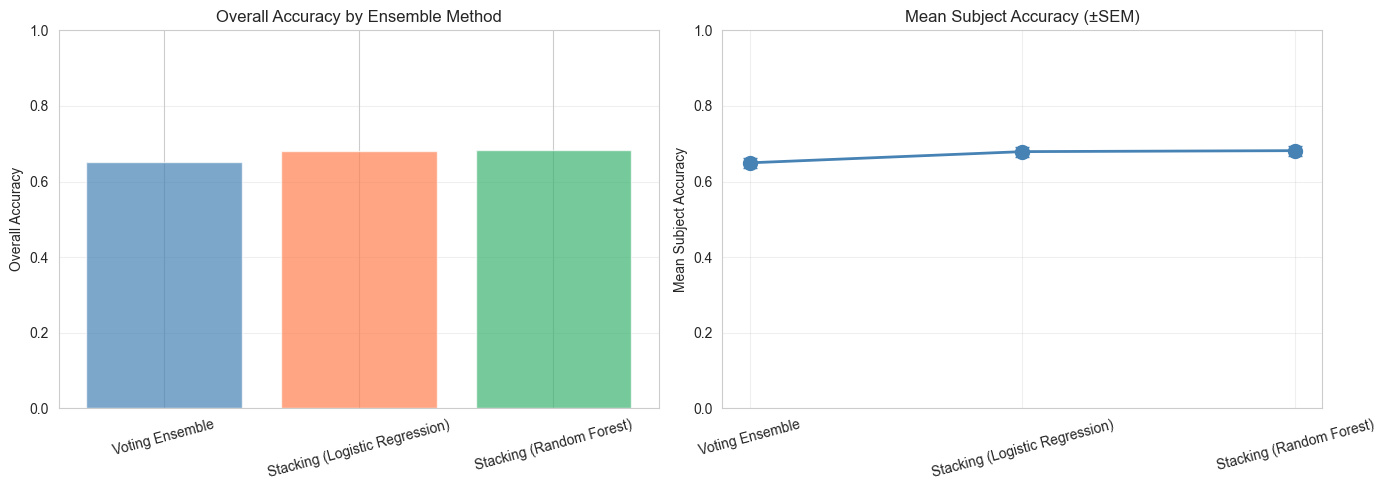

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall accuracy
colors = ['steelblue', 'coral', 'mediumseagreen']
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.7)
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy by Ensemble Method')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Mean subject accuracy
axes[1].errorbar(range(len(comparison_df)), comparison_df['Mean_Subject_Acc'],
                yerr=comparison_df['SEM_Subject_Acc'],
                marker='o', capsize=5, linewidth=2, markersize=10, color='steelblue')
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=15)
axes[1].set_ylabel('Mean Subject Accuracy')
axes[1].set_title('Mean Subject Accuracy (±SEM)')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Results

In [ ]:
# Save comparison
comparison_df.to_csv('../../data/results/analysis_outputs_{TIMEFRAME}/ensemble_comparison_{TIMEFRAME}.csv', index=False)
print("✓ Saved comparison to: ../../data/results/analysis_outputs_{TIMEFRAME}/ensemble_comparison_{TIMEFRAME}.csv")

# Save detailed results
results_dict = {
    'voting': results_voting,
    'stacking_lr': results_stacking_lr,
    'stacking_rf': results_stacking_rf
}

with open('../../data/results/model_outputs_{TIMEFRAME}/ensemble_results_{TIMEFRAME}.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("✓ Saved detailed results to: ../../data/results/model_outputs_{TIMEFRAME}/ensemble_results_{TIMEFRAME}.pkl")